In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline

## Create sample dataset

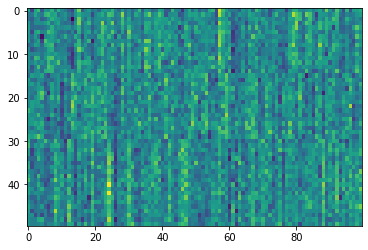

In [2]:
m, n, n_clusters = 50, 100, 3

true_centroids = np.random.randn(n_clusters, n)
true_assignments = np.random.choice(n_clusters, size=m)
true_assignments.sort()

denoised_data = np.array([true_centroids[i] for i in true_assignments])
data = denoised_data + np.random.randn(m, n)
plt.imshow(data, aspect='auto', interpolation='none')

In [3]:
from lvl.factor_models import KMeans
model = KMeans(n_components=3, n_restarts=30)
model.fit(data)

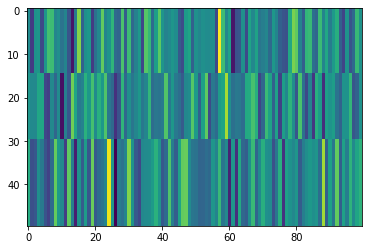

In [4]:
plt.imshow(model.predict(), aspect='auto', interpolation='none')

## Fit models, run cross-validation

#### Run cross-validation sweep for k-means clustering

In [5]:
from tqdm import tqdm
from lvl.crossval import speckled_cv_scores
from lvl.resamplers import RotationResampler

n_ranks = 5
ranks = np.arange(1, n_ranks + 1)
n_repeats = 40

# Run cross-validated k-means with speckled holdout pattern.
km_train_scores = np.ones((n_ranks, n_repeats))
km_test_scores = np.ones((n_ranks, n_repeats))

for i, rank in enumerate(tqdm(ranks)):
    model = KMeans(n_components=rank, n_restarts=30, maxiter=1000)
    km_train_scores[i], km_test_scores[i] = \
        speckled_cv_scores(model, data, n_repeats=n_repeats)

# Run cross-validated k-means on shuffled/resampled dataset.
shuff_km_train_scores = np.ones((n_ranks, n_repeats))
shuff_km_test_scores = np.ones((n_ranks, n_repeats))

for i, rank in enumerate(tqdm(ranks)):
    model = KMeans(n_components=rank, n_restarts=30, maxiter=1000)
    shuff_km_train_scores[i], shuff_km_test_scores[i] = \
        speckled_cv_scores(model, data, n_repeats=n_repeats, resampler=RotationResampler())

100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


#### Run cross-validation sweep for truncated SVD

In [6]:
from lvl.factor_models import TSVD

# Run cross-validated truncated SVD with speckled holdout pattern.
tsvd_train_scores = np.ones((n_ranks, n_repeats))
tsvd_test_scores = np.ones((n_ranks, n_repeats))

for i, rank in enumerate(tqdm(ranks)):
    model = TSVD(n_components=rank)
    tsvd_train_scores[i], tsvd_test_scores[i] = \
        speckled_cv_scores(model, data, n_repeats=n_repeats)
    
# Run cross-validated tSVD on shuffled/resampled dataset.
shuff_tsvd_train_scores = np.ones((n_ranks, n_repeats))
shuff_tsvd_test_scores = np.ones((n_ranks, n_repeats))

for i, rank in enumerate(tqdm(ranks)):
    model = TSVD(n_components=rank, method="als", maxiter=1000)
    shuff_tsvd_train_scores[i], shuff_tsvd_test_scores[i] = \
        speckled_cv_scores(model, data, n_repeats=n_repeats, resampler=RotationResampler())

100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


#### Plot cross-validation sweep results

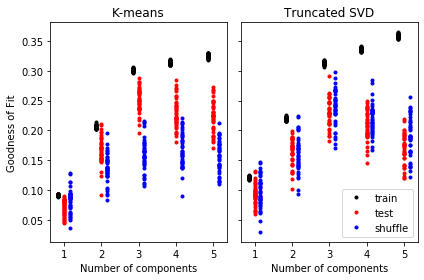

In [7]:
fig, axes = plt.subplots(1, 2, sharey=True)

rax = np.tile(ranks, (n_repeats, 1)).T.ravel()

axes[0].plot(rax-.15, km_train_scores.ravel(), '.k');
axes[0].plot(rax, km_test_scores.ravel(), '.r');
axes[0].plot(rax+.15, shuff_km_test_scores.ravel(), '.b');
axes[0].set_title("K-means")

axes[1].plot(rax-.15, tsvd_train_scores.ravel(), '.k', label='train');
axes[1].plot(rax, tsvd_test_scores.ravel(), '.r', label='test');
axes[1].plot(rax+.15, shuff_tsvd_test_scores.ravel(), '.b', label='shuffle');
axes[1].set_title("Truncated SVD")
axes[1].legend()

axes[0].set_ylabel("Goodness of Fit")
for ax in axes:
    ax.set_xlabel("Number of components")
plt.tight_layout()

## Quick demonstration of `RotationResampler` shuffling procedure

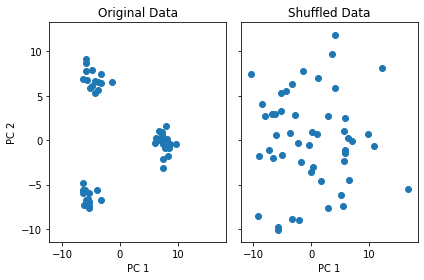

In [8]:
from sklearn.decomposition import PCA as SK_PCA

fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
axes[0].scatter(*SK_PCA(n_components=2).fit_transform(data).T)
axes[1].scatter(*SK_PCA(n_components=2).fit_transform(RotationResampler()(data)).T)
axes[0].set_title("Original Data")
axes[1].set_title("Shuffled Data")
axes[0].set_ylabel("PC 2")
axes[0].set_xlabel("PC 1")
axes[1].set_xlabel("PC 1")
fig.tight_layout()